# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append('/home/adedapo/personal_project/daps05ayoade/DeepTrade')

from secrecy import api_key
from ml_logic.scraping_stock_data import get_stock_data

In [2]:
df = get_stock_data('META', api_key)
df.head(2)

,open,high,low,close,adj_close,volume,dividend,split_coeff,ema,macd,...,upper_band,middle_band,lower_band,rsi,slowk,slowd,atr,returns,rolling_std,target
2012-07-06,31.44,31.90,31.26,31.73,31.73,10945600,0.0,1.0,31.3886,0.3856,...,33.3202,31.8066,30.2930,51.1554,55.2339,33.8792,1.2457,0.008262,0.024337,32.17
2012-07-09,32.10,32.88,31.99,32.17,32.17,17785200,0.0,1.0,31.5307,0.4432,...,33.0204,31.7186,30.4168,54.3435,69.1900,51.6306,1.2361,0.013867,0.021126,31.47


# Data Preprocessing Strategy

In the upcoming phase, I am will implement a robust data preprocessing function named `window`. This function is meticulously designed to streamline the preparation of data for time series analysis or machine learning ventures.

## Rationale Behind a 60-day Window Size

In the recent strides of my project, I've opted for a window size of 60 in processing the sequential data at hand, which is recorded on a daily basis. This specific choice of window size is far from arbitrary—it's a deliberate move to encapsulate a span of two months within each window. 

Here's why this matters:

1. **Bi-monthly Patterns**: 
   - With a window size of 60, each window spans across two months, enabling the capture of any bi-monthly patterns or trends present in the data. This timeframe can be particularly illuminating for revealing recurring phenomena or cycles that unfold over a couple of months.

2. **Meaningful Time Frame**:
   - Two months can be a significant period in many domains. It's long enough to observe meaningful trends or shifts, yet short enough to remain relevant in a rapidly changing environment. This balance makes a two-month window a pragmatic choice for dissecting the daily data.

3. **Short-term Dynamics & Longer-term Trends**:
   - A window of this size provides a harmonious blend of short-term dynamics alongside longer-term trends. It offers a vista through which the model can observe how daily fluctuations weave into the broader tapestry of bi-monthly trends, enriching its understanding and predictive prowess.

4. **Structured Temporal Context**:
   - By organizing the data into a 60-day windows, I am creating a well-structured temporal context for the models to learn from. This structure is instrumental for training time-sensitive machine learning models adept at recognizing and extrapolating temporal patterns.

This meticulous choice of window size is a testament to the nuanced approach being adopted in preprocessing the data, ensuring it's well-poised for delivering accurate and insightful analyses in the subsequent phases of the project.

In [3]:
def window(df, window_size=60):
    def split_df(df, start, end):
        split = df.iloc[start:end]
        X = split.iloc[:, :-1]
        y = split.iloc[:, -1]
        return X, y

    def window_data(X, y, window_size):
        X_windows = [X[i:i + window_size] for i in range(len(X) - window_size)]
        y_windows = [y[i + window_size] for i in range(len(X) - window_size)]
        return np.array(X_windows), np.array(y_windows)

    # Split the data
    train_size = int(len(df) * 0.7)
    val_size = int(len(df) * 0.15)
    X_train_df, y_train_df = split_df(df, 0, train_size)
    X_val_df, y_val_df = split_df(df, train_size, train_size + val_size)
    X_test_df, y_test_df = split_df(df, train_size + val_size, None)

    # Initialize the scaler
    sc = MinMaxScaler(feature_range=(0,1))
    X_train = sc.fit_transform(X_train_df).astype('float')
    X_val = sc.transform(X_val_df).astype('float')
    X_test = sc.transform(X_test_df).astype('float')
    
    y_train = y_train_df.to_numpy().astype('float')
    y_val = y_val_df.to_numpy().astype('float')
    y_test = y_test_df.to_numpy().astype('float')

    # Create windows
    X_train_windows, y_train_windows = window_data(X_train, y_train, window_size)
    X_val_windows, y_val_windows = window_data(X_val, y_val, window_size)
    X_test_windows, y_test_windows = window_data(X_test, y_test, window_size)

    return (X_train_windows, y_train_windows, X_val_windows, y_val_windows, X_test_windows, y_test_windows,
           X_train_df, y_train_df, X_val_df, y_val_df, X_test_df, y_test_df)

## Preprocessing Strategy

1. **Data Splitting**:
   - By dividing the dataset into training (70%), validation (15%), and testing (15%) segments, I am setting the stage for rigorous model evaluation and mitigating the risk of overfitting.

2. **Feature-Label Separation**:
   - Segregating each data segment into features and labels will pave the way for a clear delineation between independent and dependent variables, which is crucial for the machine learning model's comprehension and performance.
   
3. **Normalization**:
   - Employing a Min-Max Scaler, I'll ensure all features are on a uniform scale, thereby promoting faster convergence and enhancing the model’s ability to learn.

4. **Windowing**:
   - By organizing the data into overlapping windows, I am creating a structured format that mirrors the sequential nature of the data. This is instrumental for leveraging time series analysis or training sequential models like RNNs, which thrive on recognizing patterns over time.

5. **Output Preparation**:
   - The function is designed to output both the windowed data and the original segmented data, thereby offering a versatile preprocessed dataset ready for various analytical or machine learning pursuits.
   
Executing the preprocessing in this manner is a strategic move towards ensuring the data is well-primed for delving into insightful analyses and building predictive models. The organized, windowed format is particularly poised to harness the temporal dynamics inherent in the data, which is pivotal for accurate forecasting and analysis.

In [4]:
(X_train, y_train, X_val, y_val, X_test, y_test,
 X_train_df, y_train_df, X_val_df, y_val_df,
 X_test_df, y_test_df) = window(df)

# Combining X and y dataframes
train_df = pd.concat([X_train_df, y_train_df.rename('target')], axis=1).sort_index(ascending=True)
val_df = pd.concat([X_val_df, y_val_df.rename('target')], axis=1).sort_index(ascending=True)
test_df = pd.concat([X_test_df, y_test_df.rename('target')], axis=1).sort_index(ascending=True)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (1936, 60, 21)
y_train shape: (1936,)
X_test shape: (369, 60, 21)
y_test shape: (369,)


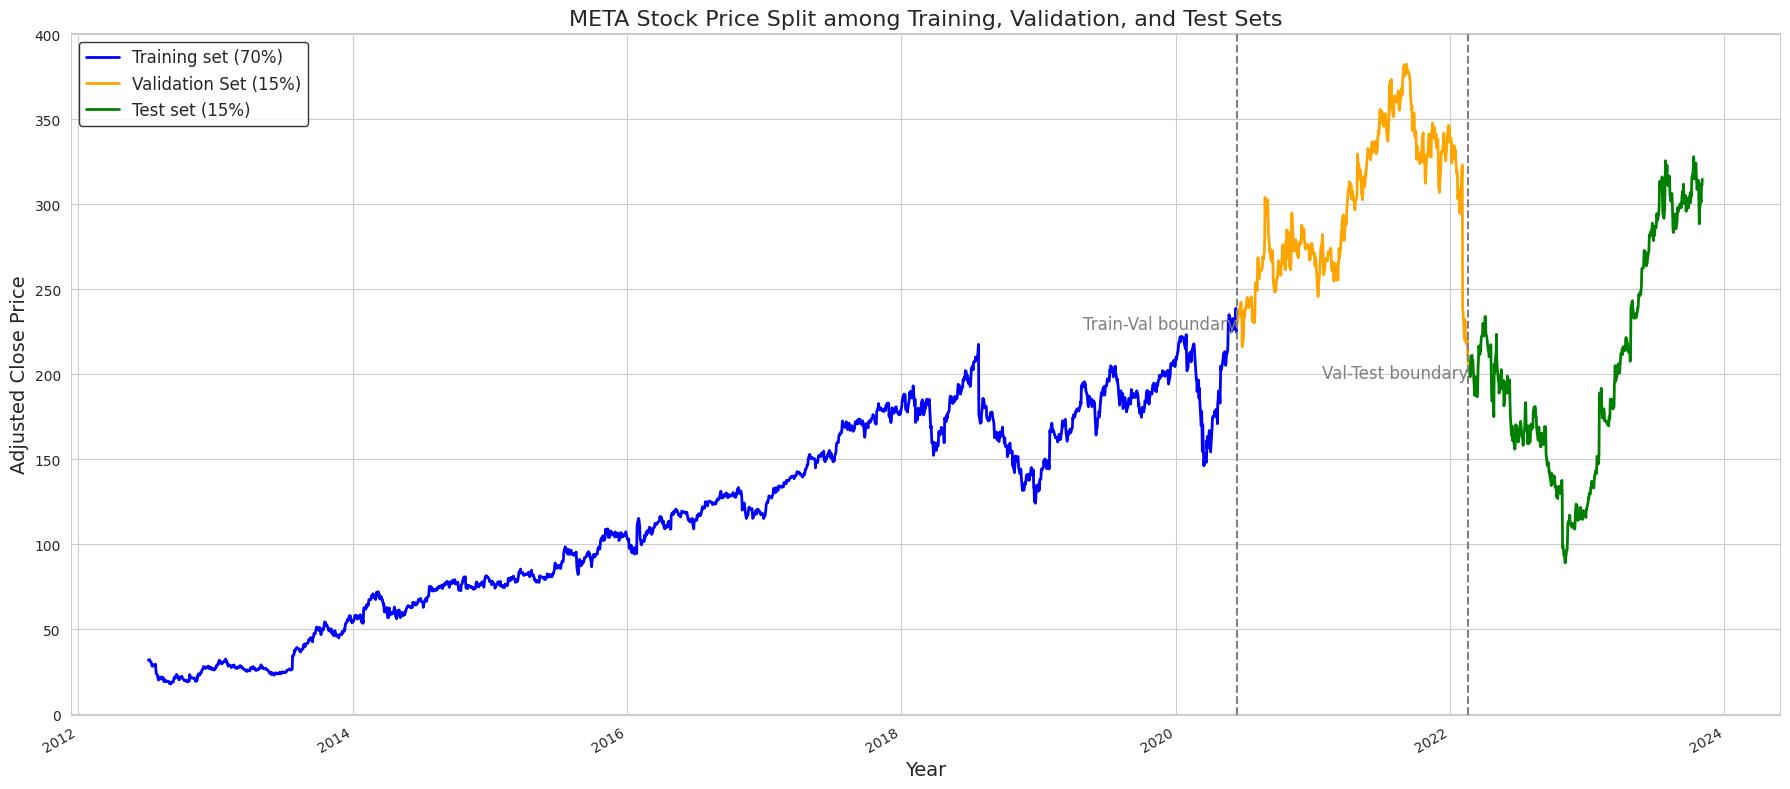

In [5]:
def plot_data(train_df, val_df, test_df, symbol):
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 8))
    train_df['adj_close'].plot(linewidth=2, color='blue')
    val_df['adj_close'].plot(linewidth=2, color='orange')
    test_df['adj_close'].plot(linewidth=2, color='green')

    plt.axvline(x=train_df.index[-1], color='grey', linestyle='--')
    plt.axvline(x=val_df.index[-1], color='grey', linestyle='--')

    plt.text(train_df.index[-1], train_df['adj_close'].iloc[-1], 'Train-Val boundary', fontsize=12, 
             verticalalignment='bottom', horizontalalignment='right', color='grey')
    plt.text(val_df.index[-1], val_df['adj_close'].iloc[-1], 'Val-Test boundary', fontsize=12, 
             verticalalignment='top', horizontalalignment='right', color='grey')

    plt.title(f'{symbol} Stock Price Split among Training, Validation, and Test Sets', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Adjusted Close Price', fontsize=14)
    plt.legend(['Training set (70%)', 'Validation Set (15%)', 'Test set (15%)'], 
               fontsize=12, loc='upper left', frameon=True, facecolor='white', edgecolor='black')

    plt.tight_layout()
    plt.show()
    
plot_data(train_df, val_df, test_df, 'META')

In [6]:
def window(df, window_size=60):
    def split_df(df, start, end):
        split = df.iloc[start:end]
        X = split.iloc[:, :-1]
        y = split.iloc[:, -1]
        return X, y

    def window_data(X, y, window_size):
        X_windows = []
        y_windows = []
        for i in range(len(X) - window_size):
            X_windows.append(X[i:i + window_size])
            y_windows.append(y[i + window_size])
        return np.array(X_windows), np.array(y_windows)

    # Split the data into train, validation and test sets
    train_size = int(len(df) * 0.7)
    val_size = int(len(df) * 0.15)
    X_train_df, y_train_df = split_df(df, 0, train_size)
    X_val_df, y_val_df = split_df(df, train_size, train_size + val_size)
    X_test_df, y_test_df = split_df(df, train_size + val_size, None)

    # Initialize the scaler
    sc = MinMaxScaler(feature_range=(0,1))

    # Fit the scaler on the training data and transform both training and testing data
    X_train = sc.fit_transform(X_train_df).astype('float')
    X_val = sc.transform(X_val_df).astype('float')
    X_test = sc.transform(X_test_df).astype('float')

    # Convert the target data to numpy arrays
    y_train = y_train_df.to_numpy().astype('float')
    y_val = y_val_df.to_numpy().astype('float')
    y_test = y_test_df.to_numpy().astype('float')

    # Create windows
    X_train_windows, y_train_windows = window_data(X_train, y_train, window_size)
    X_val_windows, y_val_windows = window_data(X_val, y_val, window_size)
    X_test_windows, y_test_windows = window_data(X_test, y_test, window_size)

    return X_train_windows, y_train_windows, X_val_windows, y_val_windows, X_test_windows, y_test_windows

In [7]:
(X_train, y_train,
X_val, y_val,
X_test, y_test) = window(df)

print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

X_train shape: (1936, 60, 21)
y_train shape: (1936,)
X_val: (367, 60, 21)
y_val: (367,)
X_test shape: (369, 60, 21)
y_test shape: (369,)
